# Dark Souls II Reviews (2025)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from get_data import *

## Steam Reviews as of 3/26/25:

In [2]:
reviews = get_data()

In [3]:
reviews.shape

(45563, 10)

## EDA:

Distribution of whether or not people recommend buying the game:

In [4]:
recommended_props = reviews[['voted_up']].value_counts(normalize=True).reset_index()

props = alt.Chart(recommended_props).mark_bar().encode(
    alt.X('voted_up', sort=[True, False], axis=alt.Axis(labelAngle=0)).title('Recommeneded'),
    alt.Y('proportion').title('Proportion'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False]),
).properties(
    width=500,
    height=300,
    title="Proportion of people who recommend playing DS2:Scholar of the First Sin (2015-2024)",
).configure_legend(
    titleFontSize=12,
    labelFontSize=12,
) 
props

alt.Chart(...)

- Most people actually recommend the game

Proportions of those who don't and do recommend DS2 in each of the years:

In [5]:
yr_props = reviews.groupby(['year', 'voted_up'])[['review']].count().reset_index()
yr_props['total_reviews'] = yr_props.groupby('year')['review'].transform('sum')
yr_props['proportion'] = yr_props['review'] / yr_props['total_reviews']

yr_count_dist_line = alt.Chart(yr_props).mark_line().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

yr_count_dist_bar = alt.Chart(yr_props).mark_bar().encode(
    alt.X('year:N', axis=alt.Axis(labelAngle=0)).title('Year'),
    alt.Y('review').title('Number of reviews'),
    alt.Color('voted_up', legend=alt.Legend(title='Recommends game?', symbolSize=300), sort=[True, False])
).properties(
    width=800,
    height=300,
    title="Count of Positive and Negative Reviews per Year (2015-2024)"
)

(
    (yr_count_dist_line & yr_count_dist_bar)
)

alt.VConcatChart(...)

- Contrary to popular belief, most people actually recommend playing the since its release back in 2015
- Game released    : April 2015 (Scholar of the First Sin edition)
- Amount of reviews during pandemic (2020-2023) was the highest amount for the game ever (at least on Steam exclusively)

## Sentiment Analysis:
- Seeing why people were positive or negative about the game
    - Comments on story, gameplay, etc

Top 10 Most Common Words in the Reviews:

In [6]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [8]:
review_txt = reviews.review.values.flatten()
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [9]:
most_unique = tfidf_df.idxmax(axis=1)
top_10 = most_unique.value_counts()[:10]
top_10

aaa      2567
good     1074
best      610
yes       407
great     267
bad       258
nice      253
git       236
fun       236
gud       233
Name: count, dtype: int64

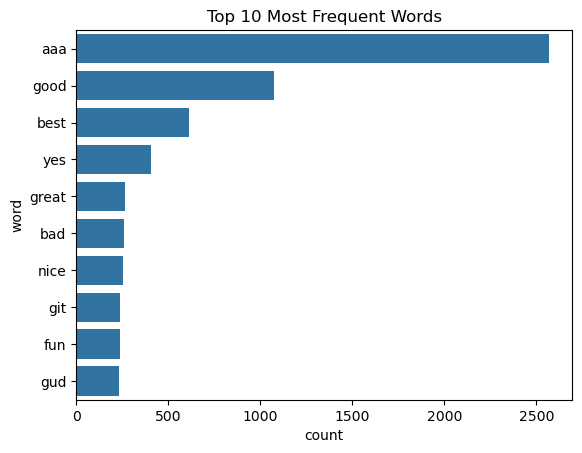

In [10]:
top_10 = top_10.reset_index()
top_10.rename(columns={'index':'word'}, inplace=True)
sns.barplot(data=top_10,
            y='word',
            x='count');
plt.title("Top 10 Most Frequent Words")
plt.show()

- Most popular word w/ semantic meaning: Triple A 
    - def: an informal classification used to classify video games produced and distributed by a mid-sized or major publisher
- Top words used seem to be positive, but this is looking at the words without context

Other popular words:

In [11]:
from wordcloud import WordCloud

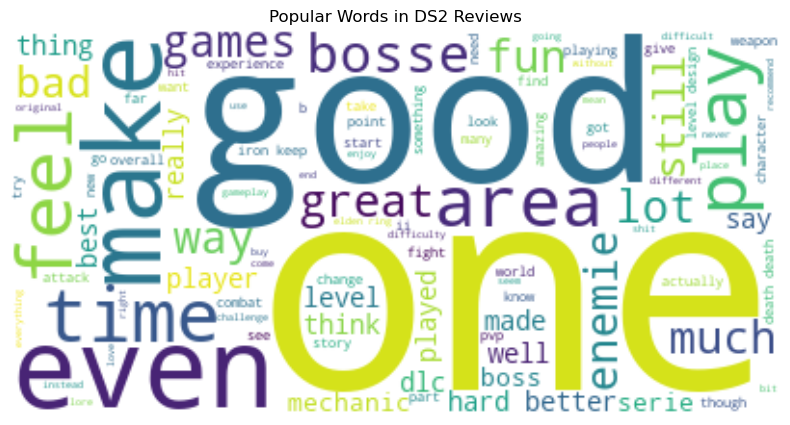

In [12]:
pop_wrds = " ".join( review for review in reviews.review)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white").generate(pop_wrds)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in DS2 Reviews')
plt.show()

- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

### Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews
    
- Algorithms I can use to perform topic modeling:
    1. Latent Dirichlet Allocation (LDA) 
    2. Non-negative Matrix Factorization (NMF)

Splitting the reviews by how many do and don't recommend buying the game:

In [13]:
pos_reviews = reviews[reviews['voted_up'] == True]
neg_reviews = reviews[reviews['voted_up'] == False]

In [14]:
pos_reviews.shape, neg_reviews.shape

((37387, 10), (8176, 10))

Function to display the output of the models:

In [15]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

LDA: Probabilistic graphical modeling, and uses CountVectorizer as input

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

In [17]:
count_vector = CountVectorizer()

tf = count_vector.fit_transform(reviews.review)
tf_feat_names = count_vector.get_feature_names_out()

pos_tf = count_vector.fit_transform(pos_reviews.review) 
pos_tf_feat_names = count_vector.get_feature_names_out()

neg_tf = count_vector.fit_transform(neg_reviews.review)
neg_tf_feat_names = count_vector.get_feature_names_out()

In [18]:
lda = LatentDirichletAllocation(n_components=3, random_state=42069)
lda.fit(tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [19]:
no_top_words = 10
display_topics(lda, tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,like,11524.7,best,5039.5,good,5374.1
1,get,6310.6,games,4158.8,love,3062.8
2,bosses,6070.2,still,3903.8,hate,2416.6
3,enemies,5887.8,series,3801.0,bad,2015.9
4,one,5711.7,one,3391.5,keep,1726.0
5,even,5286.5,great,3108.4,iron,1451.7
6,really,5281.2,play,2940.6,shit,1163.7
7,time,4923.7,played,2538.4,play,1120.4
8,boss,4895.1,better,2522.3,like,1099.9
9,good,4586.4,fun,2223.7,fucking,1065.4


- Interpreted topics that were identified:
    1. People saying how good the game is
    2. Bosses/enemies
    3. People expressing their likes or dislikes of the game

In [20]:
pos_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
pos_lda.fit(pos_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [21]:
display_topics(pos_lda, pos_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,best,4349.9,good,3182.4,like,8000.7
1,good,2934.8,love,2909.7,one,5111.6
2,still,2440.5,hate,1784.8,games,4424.7
3,fun,2219.8,die,1156.6,bosses,4394.6
4,great,2179.7,keep,1058.1,get,4309.3
5,series,2058.2,like,936.2,still,4025.3
6,one,1716.9,play,911.6,really,3902.0
7,yes,1644.9,died,871.5,much,3858.8
8,games,1601.7,ii,868.0,better,3705.2
9,ever,1074.8,iron,839.0,even,3620.2


In [22]:
neg_lda = LatentDirichletAllocation(n_components=3, random_state=42069)
neg_lda.fit(neg_tf)

LatentDirichletAllocation(n_components=3, random_state=42069)

In [23]:
display_topics(neg_lda, neg_tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,bad,620.5,like,1769.6,like,1774.6
1,like,515.8,bosses,1729.7,even,1642.6
2,one,389.3,boss,1484.6,get,1416.1
3,time,312.3,enemies,1398.7,one,1216.1
4,level,237.1,play,1328.8,play,1119.4
5,play,228.8,trash,1104.2,enemies,1091.0
6,design,226.6,good,1049.8,time,1044.7
7,good,200.8,worst,1046.9,way,884.5
8,sucks,193.9,games,1010.0,games,862.0
9,enemies,185.3,one,961.6,make,855.6


- Interpreted topics that were identified:
    1. Bosses/enemies
    2. Controls/PC port of the game
    3. Players' comments on that it's the worst Dark Souls game they've played

NMF: Linear algebra and uses the TF-IDF vectorizer as input

In [24]:
from sklearn.decomposition import NMF

In [25]:
nmf = NMF(n_components=3, random_state=42069)
nmf.fit(tfidf_array)

NMF(n_components=3, random_state=42069)

In [26]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,good,6.4,best,5.7,like,1.2
1,pretty,0.3,ever,0.7,fun,1.0
2,still,0.2,series,0.4,great,0.9
3,really,0.1,one,0.3,still,0.9
4,get,0.1,games,0.2,one,0.9
5,actually,0.0,pvp,0.2,play,0.9
6,bad,0.0,played,0.1,games,0.8
7,hard,0.0,made,0.1,bad,0.8
8,worst,0.0,trilogy,0.1,better,0.7
9,yes,0.0,worst,0.1,get,0.6


In [27]:
pos_txt = pos_reviews.review.values.flatten()
pos_tfidf_array = tfidf.fit_transform(pos_txt).toarray()
nmf.fit(pos_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [28]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,good,6.2,best,5.5,great,1.3
1,pretty,0.3,ever,0.7,fun,1.2
2,still,0.2,series,0.4,like,1.2
3,really,0.1,one,0.3,still,1.0
4,bad,0.1,games,0.2,one,0.9
5,get,0.1,pvp,0.2,games,0.9
6,actually,0.0,played,0.1,play,0.8
7,worst,0.0,made,0.1,better,0.7
8,hard,0.0,trilogy,0.1,love,0.6
9,yeah,0.0,fight,0.1,series,0.6


- Interpreted topics that were identified:
    1. Positive outloooks on the game
    2. similar to 1st topic
    3. People expressing their opinion on the game, ranging from good to bad

In [29]:
neg_txt = neg_reviews.review.values.flatten()
neg_tfidf_array = tfidf.fit_transform(neg_txt).toarray()
nmf.fit(neg_tfidf_array)

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF(n_components=3, random_state=42069)

In [30]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,like,0.9,bad,3.3,shit,2.7
1,play,0.8,really,0.1,sucks,1.3
2,one,0.7,design,0.1,fucking,0.5
3,worst,0.7,kinda,0.0,ass,0.3
4,good,0.7,genuinely,0.0,piece,0.2
5,games,0.6,port,0.0,trash,0.2
6,get,0.5,play,0.0,fuck,0.2
7,even,0.5,general,0.0,buy,0.2
8,enemies,0.5,say,0.0,dog,0.2
9,time,0.5,still,0.0,still,0.1


- Interpreted topics that were identified:
    1. Vague but concerned w/ enemies
    2. Very negative perspectives on the game
    3. Negative experience regarding bosses, hitboxes, and game design